In [49]:
import pandas as pd
import numpy as np
import ast
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.metrics import roc_auc_score, roc_curve, auc
import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import load_model

In [2]:
train_df = pd.read_parquet('data/train.parquet')
test_df = pd.read_parquet('data/test.parquet')

In [3]:
train_df.head(10)

,id,dates,values,label
0,19114,"[2016-01-01, 2016-02-01, 2016-03-01, 2016-04-0...","[-1.86, 0.79, 1.4, 0.15, 0.0, -1.24, -1.46, 3....",0.0
1,22769,"[2016-05-01, 2016-06-01, 2016-07-01, 2016-08-0...","[-1.04, -3.48, 0.05, -0.13, -0.01, 0.03, 0.27,...",1.0
2,76935,"[2017-03-01, 2017-04-01, 2017-05-01, 2017-06-0...","[0.28, 0.63, 0.06, 0.96, -1.4, -0.3, 1.62, 1.1...",0.0
3,66297,"[2016-01-01, 2016-02-01, 2016-03-01, 2016-04-0...","[-0.33, 0.58, 1.1, -0.56, -0.95, -0.61, -0.7, ...",0.0
4,2191,"[2016-01-01, 2016-02-01, 2016-03-01, 2016-04-0...","[1.31, 0.5, -0.54, 0.95, 0.65, 0.83, -1.55, -0...",0.0
5,59504,"[2016-03-01, 2016-04-01, 2016-05-01, 2016-06-0...","[0.08, 0.88, 1.46, 0.59, -0.97, -0.41, 0.78, -...",0.0
6,49554,"[2016-04-01, 2016-05-01, 2016-06-01, 2016-07-0...","[1.05, -0.28, 1.09, -0.69, 1.26, 1.79, 1.38, -...",0.0
7,58344,"[2016-12-01, 2017-01-01, 2017-02-01, 2017-03-0...","[-0.36, -0.45, -0.4, -0.4, -0.45, -0.45, -0.45...",0.0
8,87449,"[2016-01-01, 2016-02-01, 2016-03-01, 2016-04-0...","[2.92, 4.11, 3.39, -1.17, -0.79, 2.15, -0.22, ...",1.0
9,43415,"[2016-02-01, 2016-03-01, 2016-04-01, 2016-05-0...","[-0.86, -0.05, -0.35, -0.67, -0.25, -0.8, -0.6...",1.0


In [4]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 80000 entries, 0 to 79999
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   id      80000 non-null  int64  
 1   dates   80000 non-null  object 
 2   values  80000 non-null  object 
 3   label   80000 non-null  float64
dtypes: float64(1), int64(1), object(2)
memory usage: 2.4+ MB


# EDA

**Тренды по времени**

Мы не можем напрямую строить график всех значений по датам, так как каждая запись содержит списки дат и значений. Мы построим график для каждого конкретного id.

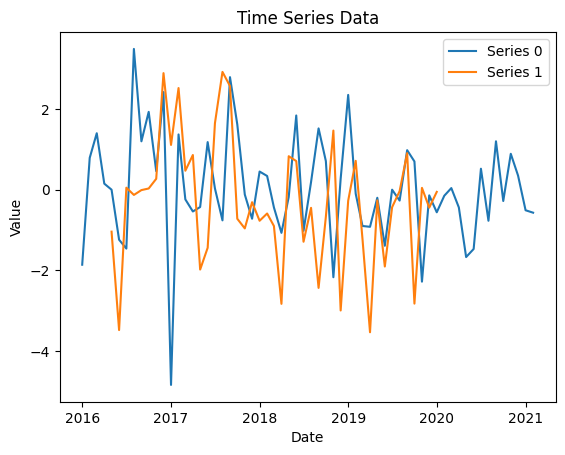

In [5]:
# Визуализация данных для первых 2 записей
for i in range(2):
    plt.plot(train_df['dates'].iloc[i], train_df['values'].iloc[i], label=f"Series {i}")
    
plt.xlabel('Date')
plt.ylabel('Value')
plt.title('Time Series Data')
plt.legend()
plt.show()


Анализ сезонности
Для анализа сезонности нужно добавить столбцы с годом и месяцем, что можно сделать для каждого временного ряда.

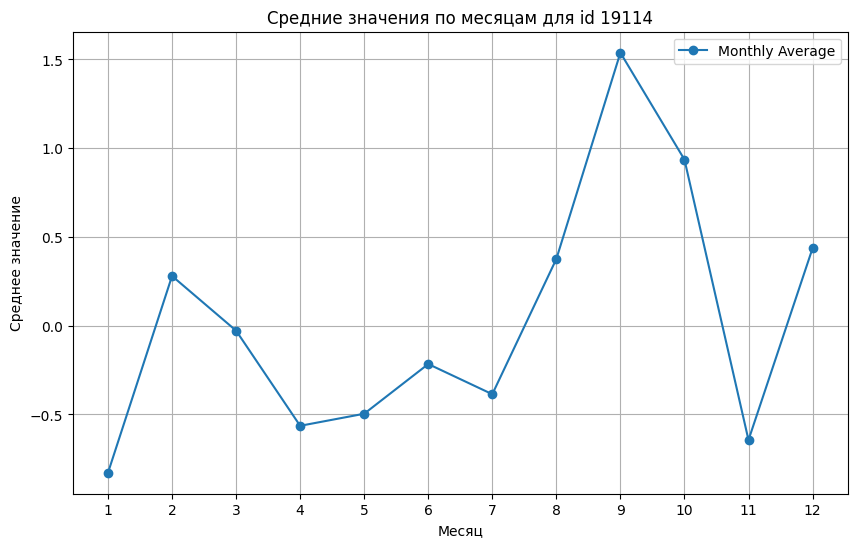

In [6]:
import matplotlib.pyplot as plt

# Функция для извлечения года и месяца из дат
def extract_seasonal_features(dates):
    dates = pd.to_datetime(dates)
    return pd.DataFrame({
        'year': dates.year,
        'month': dates.month
    })

# Извлекаем год и месяц для примера
seasonal_features = extract_seasonal_features(train_df.iloc[0]['dates'])

# Добавляем столбцы 'year' и 'month' для анализа сезонности
train_df['year'] = seasonal_features['year']
train_df['month'] = seasonal_features['month']

test_df['year'] = seasonal_features['year']
test_df['month'] = seasonal_features['month']


# Построим график для среднего значения по месяцам для конкретного id
monthly_mean = pd.DataFrame(train_df.iloc[0]['values'], columns=['values']).groupby(train_df['month']).mean()
plt.figure(figsize=(10, 6))
plt.plot(monthly_mean.index, monthly_mean['values'], marker='o', label='Monthly Average')
plt.title(f'Средние значения по месяцам для id {train_df.iloc[0]["id"]}')
plt.xlabel('Месяц')
plt.ylabel('Среднее значение')
plt.xticks(ticks=range(1, 13))
plt.legend()
plt.grid(True)
plt.show()


Гистограммы распределения значений для каждого класса
Здесь нужно учитывать, что values — это списки, поэтому необходимо развернуть значения.

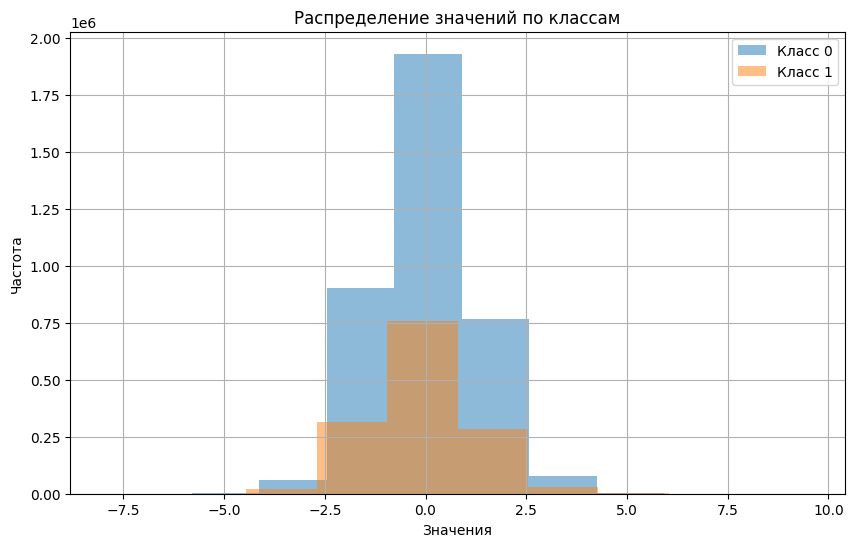

In [7]:
# Разворачиваем данные
values_class_0 = [val for sublist in train_df[train_df['label'] == 0]['values'] for val in sublist]
values_class_1 = [val for sublist in train_df[train_df['label'] == 1]['values'] for val in sublist]

# Построим гистограммы распределения значений для классов 0 и 1
plt.figure(figsize=(10, 6))
plt.hist(values_class_0, alpha=0.5, label='Класс 0')
plt.hist(values_class_1, alpha=0.5, label='Класс 1')
plt.title('Распределение значений по классам')
plt.xlabel('Значения')
plt.ylabel('Частота')
plt.legend()
plt.grid(True)
plt.show()


In [8]:
# Преобразуем даты в ординальные числа для конкретного id
dates = pd.to_datetime(train_df.iloc[0]['dates']).map(lambda x: x.toordinal())
values = train_df.iloc[0]['values']

# Рассчитаем корреляцию
df_corr = pd.DataFrame({'date_ordinal': dates, 'values': values})
correlation = df_corr.corr()

print(f"Корреляция значений с временем для id {train_df.iloc[0]['id']}:\n{correlation}")


Корреляция значений с временем для id 19114:
              date_ordinal    values
date_ordinal      1.000000 -0.149984
values           -0.149984  1.000000


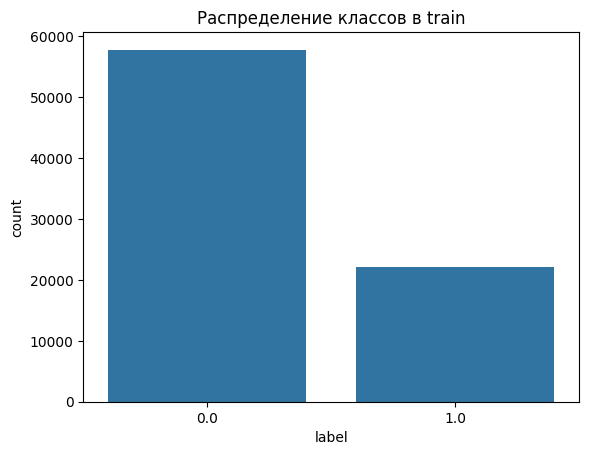

In [9]:
sns.countplot(x='label', data=train_df)
plt.title("Распределение классов в train")
plt.show()


In [10]:
train_df


,id,dates,values,label,year,month
0,19114,"[2016-01-01, 2016-02-01, 2016-03-01, 2016-04-0...","[-1.86, 0.79, 1.4, 0.15, 0.0, -1.24, -1.46, 3....",0.0,2016.0,1.0
1,22769,"[2016-05-01, 2016-06-01, 2016-07-01, 2016-08-0...","[-1.04, -3.48, 0.05, -0.13, -0.01, 0.03, 0.27,...",1.0,2016.0,2.0
2,76935,"[2017-03-01, 2017-04-01, 2017-05-01, 2017-06-0...","[0.28, 0.63, 0.06, 0.96, -1.4, -0.3, 1.62, 1.1...",0.0,2016.0,3.0
3,66297,"[2016-01-01, 2016-02-01, 2016-03-01, 2016-04-0...","[-0.33, 0.58, 1.1, -0.56, -0.95, -0.61, -0.7, ...",0.0,2016.0,4.0
4,2191,"[2016-01-01, 2016-02-01, 2016-03-01, 2016-04-0...","[1.31, 0.5, -0.54, 0.95, 0.65, 0.83, -1.55, -0...",0.0,2016.0,5.0
...,...,...,...,...,...,...
79995,71474,"[2018-10-01, 2018-11-01, 2018-12-01, 2019-01-0...","[-0.15, -1.13, -0.87, 0.49, 0.87, 1.67, 1.91, ...",0.0,NaN,NaN
79996,36908,"[2016-07-01, 2016-08-01, 2016-09-01, 2016-10-0...","[-0.35, -1.31, 0.11, 1.46, 1.28, 1.12, 1.78, 1...",1.0,NaN,NaN
79997,63517,"[2016-03-01, 2016-04-01, 2016-05-01, 2016-06-0...","[-0.78, -2.27, -1.85, -0.67, -1.2, -2.02, 0.12...",0.0,NaN,NaN
79998,94731,"[2016-02-01, 2016-03-01, 2016-04-01, 2016-05-0...","[-2.29, -2.85, 0.92, -0.83, -1.75, -1.81, -2.2...",0.0,NaN,NaN


# Feature generating

In [11]:
import numpy as np
import pandas as pd
from scipy.stats import skew, kurtosis
from sklearn.linear_model import LinearRegression

def generate_features_from_time_series(df):
    features = []
    
    # Признаки для каждого временного ряда (id)
    for index, row in df.iterrows():
        dates = pd.to_datetime(row['dates'])
        values = np.array(row['values'])
        
        # Проверяем наличие NaN значений
        if np.any(np.isnan(values)):
            continue  # Пропускаем строки с NaN значениями

        # 1. Статистические признаки
        mean_value = np.mean(values)
        std_dev = np.std(values)
        min_value = np.min(values)
        max_value = np.max(values)
        q25 = np.percentile(values, 25)
        q50 = np.percentile(values, 50)
        q75 = np.percentile(values, 75)
        skewness = skew(values)
        kurt = kurtosis(values)
        
        # 2. Признаки тренда (используем линейную регрессию)
        X = np.arange(len(values)).reshape(-1, 1)  # Индексы как X для линейной регрессии
        reg = LinearRegression().fit(X, values)
        slope = reg.coef_[0]  # Коэффициент наклона линии тренда
        intercept = reg.intercept_
        
        # 3. Сезонные признаки
        month_mean = [np.mean(values[dates.month == i]) for i in range(1, 13)]
        
        # 4. Признаки изменений
        diffs = np.diff(values)
        zero_crossings = np.count_nonzero(np.diff(np.sign(values)))
        
        # Соберём все признаки в один список
        features.append([
            mean_value,
            std_dev,
            min_value,
            max_value,
            q25,
            q50,
            q75,
            skewness,
            kurt,
            slope,
            intercept,
            *month_mean,  # Средние значения по месяцам
            np.mean(diffs),  # Среднее изменение
            zero_crossings  # Количество пересечений с нулевой линией
        ])
    
    # Преобразуем признаки в DataFrame
    feature_names = [
        'mean', 'std_dev', 'min', 'max', 'q25', 'q50', 'q75', 
        'skewness', 'kurtosis', 'slope', 'intercept',
        'month_1', 'month_2', 'month_3', 'month_4', 'month_5', 'month_6', 
        'month_7', 'month_8', 'month_9', 'month_10', 'month_11', 'month_12',
        'mean_diff', 'zero_crossings'
    ]
    
    features_df = pd.DataFrame(features, columns=feature_names)
    return features_df

# Генерируем признаки из обучающей выборки
train_features = generate_features_from_time_series(train_df)
train_features.head()


,mean,std_dev,min,max,q25,q50,q75,skewness,kurtosis,slope,...,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12,mean_diff,zero_crossings
0,0.023710,1.337272,-4.840000,3.49,-0.6825,-0.110000,0.7700,-0.304166,1.889654,-0.011222,...,-0.496000,-0.216000,-0.386000,0.376000,1.538000,0.936000,-0.644000,0.436000,0.021148,31
1,-0.310777,1.556337,-3.534409,2.92,-1.0400,-0.274409,0.7100,-0.011952,-0.107257,-0.026755,...,-0.613602,-1.528602,-0.006102,0.576398,0.257795,-1.047205,0.205295,-0.214705,0.022400,16
2,-0.046042,1.065023,-1.950000,2.61,-0.8775,-0.145000,0.6150,0.377148,-0.272738,-0.032482,...,-0.400000,-0.272500,-1.227500,-1.212500,0.150000,0.480000,0.612500,0.210000,-0.014894,9
3,-0.130000,1.158201,-2.220000,2.49,-0.9500,-0.345000,0.8250,0.112395,-0.849629,0.049298,...,-0.890000,-0.572500,-0.455000,-0.855000,-0.200000,-0.177500,-0.005000,0.802500,0.040851,11
4,-0.270536,1.270529,-2.500000,2.87,-1.2500,-0.475000,0.6775,0.398655,-0.587199,-0.011478,...,1.246000,-0.928000,-2.004000,-0.760000,-1.362500,-0.247500,0.452500,-0.772500,-0.037455,25


In [12]:
test_features = generate_features_from_time_series(test_df)

# Гипотезы

**Гипотеза 1: Корреляция тренда с меткой**
Гипотеза: Если временной ряд имеет положительный тренд (увеличение значения со временем), это может быть связано с меткой 1 (положительный класс).

**Обоснование**: Признак тренда (например, коэффициент наклона линейной регрессии) может показывать увеличение значений, что указывает на растущий тренд. Возможно, определенные классы связаны с таким трендом.

**Гипотеза 2: Влияние сезонности на метку**
Гипотеза: Если значения временного ряда достигают пиковых значений в определенные месяцы, это может быть связано с определенным классом.

**Обоснование**: Признак сезонности (например, месячные колебания) может указывать на то, что определенные периоды времени имеют важное значение для классификации, например, летом или зимой.

**Гипотеза 3: Сильные колебания (волатильность) и метка**
Гипотеза: Временные ряды с высокой волатильностью (большими колебаниями значений) чаще соответствуют метке 0 (отрицательный класс).

**Обоснование**: Высокая волатильность может свидетельствовать о нестабильных или непредсказуемых данных, что может быть связано с определенным классом.

**Гипотеза 4: Признак средней скользящей и метка**
Гипотеза: Если значения скользящего среднего находятся выше определенного порога, это может быть связано с классом 1.

**Обоснование**: Скользящее среднее может показывать общий тренд в данных. Высокие значения скользящего среднего могут указывать на более высокие значения в целом, что может быть связано с положительным классом.

**Гипотеза 5: Признак суммы значений по времени и метка**
Гипотеза: Если сумма значений временного ряда за определенный период времени высока, это может быть связано с меткой 1.

**Обоснование**: Большая сумма значений может указывать на длительный период стабильно положительных изменений, что может указывать на положительный класс.

## Гипотеза 1: Корреляция тренда с меткой
Гипотеза: Если временной ряд имеет положительный тренд (увеличение значения со временем), это может быть связано с меткой 1 (положительный класс).

In [13]:
# Функция для вычисления наклона тренда (linear regression)
def compute_trend_slope(dates, values):
    # Преобразуем даты в числовой формат (например, количество дней с начала периода)
    days_since_start = np.arange(len(dates)).reshape(-1, 1)
    
    # Удаляем строки с NaN значениями в 'values'
    valid_data = ~np.isnan(values)
    days_since_start = days_since_start[valid_data]
    values = values[valid_data]
    
    if len(values) <= 1:  # Пропускаем ряды с недостаточным количеством данных
        return np.nan
    
    # Применяем линейную регрессию для нахождения наклона
    model = LinearRegression()
    model.fit(days_since_start, values)
    return model.coef_[0]

# Список для хранения трендов
trends = []

# Вычисляем тренды для всех временных рядов
for i in range(len(train_df)):
    dates = pd.to_datetime(train_df.loc[i, 'dates'])
    values = np.array(train_df.loc[i, 'values'])
    
    if len(dates) > 1:
        slope = compute_trend_slope(dates, values)
        # Классифицируем тренд как положительный или отрицательный
        trend_direction = 1 if slope > 0 else 0
        trends.append((train_df.loc[i, 'label'], trend_direction))

# Преобразуем в DataFrame
trends_df = pd.DataFrame(trends, columns=['label', 'trend_positive'])

# Теперь посмотрим распределение классов среди временных рядов с положительным и отрицательным трендом
positive_trend_class1 = trends_df[(trends_df['trend_positive'] == 1) & (trends_df['label'] == 1)].shape[0]
positive_trend_class0 = trends_df[(trends_df['trend_positive'] == 1) & (trends_df['label'] == 0)].shape[0]

negative_trend_class1 = trends_df[(trends_df['trend_positive'] == 0) & (trends_df['label'] == 1)].shape[0]
negative_trend_class0 = trends_df[(trends_df['trend_positive'] == 0) & (trends_df['label'] == 0)].shape[0]

# Выведем результаты
print(f"Положительный тренд и метка 1: {positive_trend_class1}")
print(f"Положительный тренд и метка 0: {positive_trend_class0}")
print(f"Отрицательный тренд и метка 1: {negative_trend_class1}")
print(f"Отрицательный тренд и метка 0: {negative_trend_class0}")

# Процент положительных трендов, которые относятся к классу 1
percent_positive_trend_class1 = (positive_trend_class1 / (positive_trend_class1 + positive_trend_class0)) * 100
percent_negative_trend_class1 = (negative_trend_class1 / (negative_trend_class1 + negative_trend_class0)) * 100

print(f"Процент временных рядов с положительным трендом, принадлежащих к классу 1: {percent_positive_trend_class1:.2f}%")
print(f"Процент временных рядов с отрицательным трендом, принадлежащих к классу 1: {percent_negative_trend_class1:.2f}%")


Положительный тренд и метка 1: 4662
Положительный тренд и метка 0: 25804
Отрицательный тренд и метка 1: 17518
Отрицательный тренд и метка 0: 32016
Процент временных рядов с положительным трендом, принадлежащих к классу 1: 15.30%
Процент временных рядов с отрицательным трендом, принадлежащих к классу 1: 35.37%


Только 15.30% временных рядов с положительным трендом принадлежат к классу 1, что указывает на слабую связь положительного тренда с положительным классом.
Однако 35.37% временных рядов с отрицательным трендом принадлежат к классу 1, что является более значительным показателем.

Вывод:
Эти данные не подтверждают гипотезу, что положительные тренды сильно связаны с меткой 1. Напротив, отрицательные тренды более вероятно связаны с меткой 1.

## Гипотеза 2: Влияние сезонности на метку
Гипотеза: Если значения временного ряда достигают пиковых значений в определенные месяцы, это может быть связано с определенным классом.

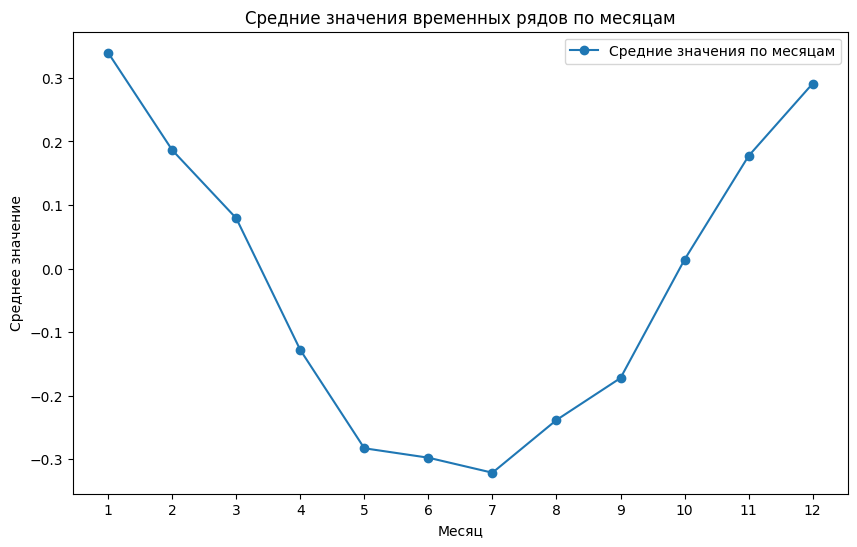

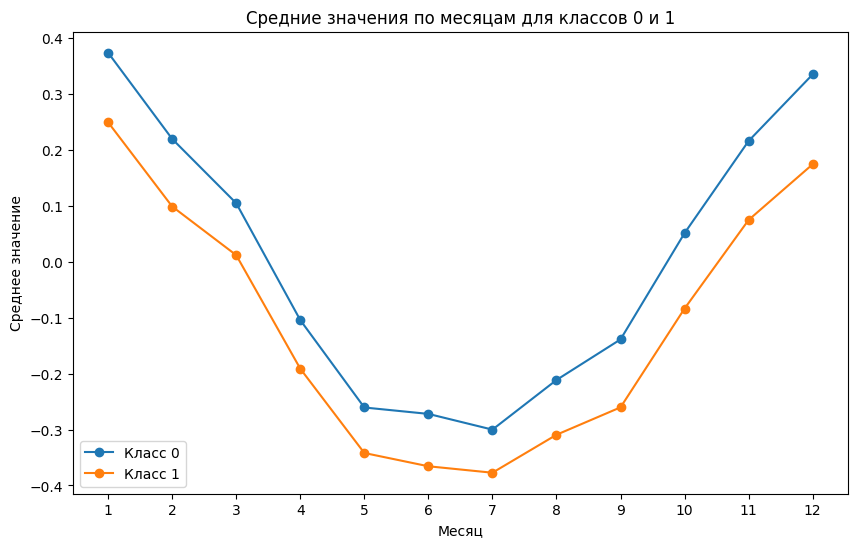

In [14]:
# Развернем списки дат и значений для каждой записи
train_exploded = train_df.explode(['dates', 'values']).reset_index(drop=True)

# Преобразуем столбец 'dates' в datetime формат
train_exploded['dates'] = pd.to_datetime(train_exploded['dates'])

# Добавляем столбцы 'year' и 'month'
train_exploded['year'] = train_exploded['dates'].dt.year
train_exploded['month'] = train_exploded['dates'].dt.month

# Рассчитываем средние значения для каждого месяца
monthly_mean = train_exploded.groupby('month')['values'].mean()

# Строим график средних значений по месяцам
plt.figure(figsize=(10, 6))
plt.plot(monthly_mean.index, monthly_mean.values, marker='o', label='Средние значения по месяцам')
plt.title('Средние значения временных рядов по месяцам')
plt.xlabel('Месяц')
plt.ylabel('Среднее значение')
plt.xticks(ticks=range(1, 13))
plt.legend()
plt.show()

# Для сравнения классов: добавим класс в группировку
monthly_mean_class = train_exploded.groupby(['month', 'label'])['values'].mean().unstack()

# Строим график для классов 0 и 1
plt.figure(figsize=(10, 6))
plt.plot(monthly_mean_class.index, monthly_mean_class[0], marker='o', label='Класс 0')
plt.plot(monthly_mean_class.index, monthly_mean_class[1], marker='o', label='Класс 1')
plt.title('Средние значения по месяцам для классов 0 и 1')
plt.xlabel('Месяц')
plt.ylabel('Среднее значение')
plt.xticks(ticks=range(1, 13))
plt.legend()
plt.show()


**Первый график (средние значения временных рядов по месяцам)**:

Этот график подтверждает, что временные ряды имеют явные сезонные колебания, где самые низкие значения приходятся на май-июнь, а самые высокие — на декабрь-январь.
Сезонные циклы могут служить важным признаком для классификации, особенно если такие закономерности наблюдаются во всех временных рядах.

**Второй график (средние значения по месяцам для классов 0 и 1)**:

Видно, что значения временных рядов для классов 0 и 1 меняются сезонно: в зимние месяцы (около декабря и января) значения временных рядов возрастают, а в летние месяцы (май-июль) наблюдается падение.
Класс 0 имеет в целом более высокие средние значения, чем класс 1, независимо от месяца.
Разрыв между классами наблюдается на протяжении всех месяцев, что может указывать на то, что месячные сезонные изменения могут быть связаны с классом.

**Выводы:**

Первый график подтверждает, что в данных явно выражены сезонные колебания, что может свидетельствовать о значимом влиянии времени года на динамику временных рядов.
Второй график показывает, что класс 0 и класс 1 имеют различное поведение по месяцам, что может быть полезным для построения классификационной модели. Разница в среднем уровне рядов по классам наблюдается в течение всего года, хотя оба класса следуют общему тренду сезонности.
Эти результаты можно использовать для проверки гипотезы о том, что временной ряд может быть связан с меткой (классом) в зависимости от месяца.

## Гипотеза 3: Статистическая связь амплитуды изменений с классом.
Гипотеза: Временные ряды с более высокой амплитудой изменений (размах значений) могут быть связаны с классом 1 (положительный класс).

Для проверки этой гипотезы тебе нужно рассчитать амплитуду изменений (размах значений) для каждого временного ряда, а затем сравнить распределение амплитуд для классов 0 и 1.

Рассчитаем амплитуду для каждого временного ряда:

In [15]:
# Добавляем столбец с амплитудой для каждого ряда
train_df['amplitude'] = train_df['values'].apply(lambda x: max(x) - min(x))
test_df['amplitude'] = test_df['values'].apply(lambda x: max(x) - min(x))

train_df[['id', 'amplitude', 'label']].head()


,id,amplitude,label
0,19114,8.330000,0.0
1,22769,6.454409,1.0
2,76935,4.560000,0.0
3,66297,4.710000,0.0
4,2191,5.370000,0.0


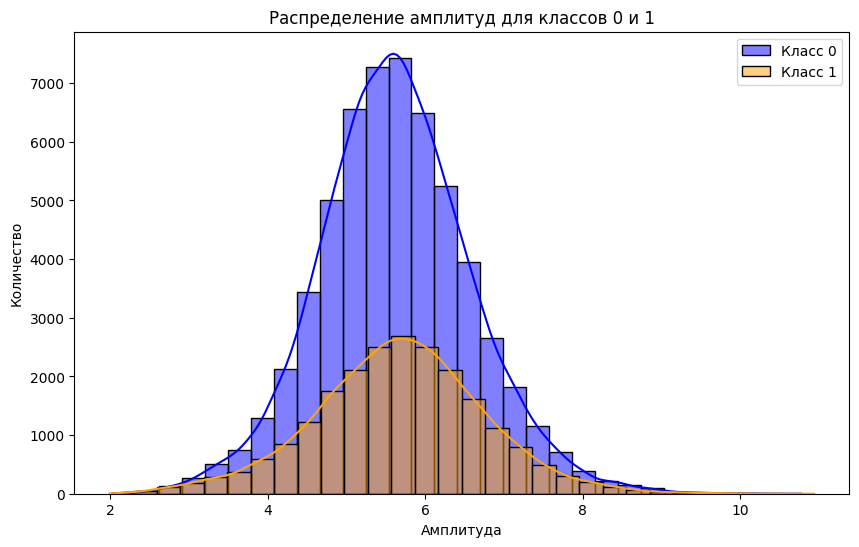

In [16]:
# Строим гистограммы амплитуд для классов 0 и 1
plt.figure(figsize=(10, 6))
sns.histplot(train_df[train_df['label'] == 0]['amplitude'], color='blue', kde=True, label='Класс 0', bins=30)
sns.histplot(train_df[train_df['label'] == 1]['amplitude'], color='orange', kde=True, label='Класс 1', bins=30)
plt.title('Распределение амплитуд для классов 0 и 1')
plt.xlabel('Амплитуда')
plt.ylabel('Количество')
plt.legend()
plt.show()


Чтобы подтвердить гипотезу, можно провести статистический тест, например, t-тест или Mann-Whitney U тест, который проверит, есть ли значимая разница между амплитудами для классов.

In [17]:
print(train_df['amplitude'].isna().sum())

train_df = train_df.dropna(subset=['amplitude'])

88


In [18]:
from scipy.stats import mannwhitneyu

# Разделяем данные по классам
amplitude_class_0 = train_df[train_df['label'] == 0]['amplitude']
amplitude_class_1 = train_df[train_df['label'] == 1]['amplitude']

# Проводим тест Манна-Уитни
stat, p_value = mannwhitneyu(amplitude_class_0, amplitude_class_1)

# Выводим результат
print(f"U-статистика: {stat}, p-значение: {p_value}")

# Интерпретация
if p_value < 0.05:
    print("Существуют статистически значимые различия в амплитуде между классами 0 и 1.")
else:
    print("Статистически значимых различий в амплитуде между классами 0 и 1 не обнаружено.")


U-статистика: 614355013.0, p-значение: 1.2294316188285057e-17
Существуют статистически значимые различия в амплитуде между классами 0 и 1.


Различия в амплитуде временных рядов между классами 0 и 1 не случайны.
Класс 0 и класс 1 имеют значимые различия в своих амплитудах, что можно использовать для дальнейшей классификации.

## Гипотеза 4: Признак средней скользящей и метка
Гипотеза: Если значения скользящего среднего находятся выше определенного порога, это может быть связано с классом 1.

In [19]:
# Рассчитаем скользящее среднее с окном 3 для временных рядов
window_size = 3
train_df['moving_avg'] = train_df['values'].apply(lambda x: np.convolve(x, np.ones(window_size)/window_size, mode='valid'))
test_df['moving_avg'] = test_df['values'].apply(lambda x: np.convolve(x, np.ones(window_size)/window_size, mode='valid'))

# Установим пороговое значение (например, 0)
threshold = 0

# Разделим данные по классу метки и проверим, сколько рядов превышают порог
above_threshold_class_1 = (train_df[train_df['label'] == 1]['moving_avg'].apply(lambda x: np.mean(x) > threshold)).sum()
above_threshold_class_0 = (train_df[train_df['label'] == 0]['moving_avg'].apply(lambda x: np.mean(x) > threshold)).sum()

# Общие количества для каждого класса
total_class_1 = len(train_df[train_df['label'] == 1])
total_class_0 = len(train_df[train_df['label'] == 0])

# Выводим результаты
print(f"Класс 1: {above_threshold_class_1}/{total_class_1} временных рядов превышают порог")
print(f"Класс 0: {above_threshold_class_0}/{total_class_0} временных рядов превышают порог")

# Процентное соотношение
percent_above_threshold_class_1 = above_threshold_class_1 / total_class_1 * 100
percent_above_threshold_class_0 = above_threshold_class_0 / total_class_0 * 100

print(f"Процент временных рядов класса 1, превышающих порог: {percent_above_threshold_class_1:.2f}%")
print(f"Процент временных рядов класса 0, превышающих порог: {percent_above_threshold_class_0:.2f}%")


C:\Users\rusbe\AppData\Local\Temp\ipykernel_4848\4158290137.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df['moving_avg'] = train_df['values'].apply(lambda x: np.convolve(x, np.ones(window_size)/window_size, mode='valid'))


Класс 1: 2612/22127 временных рядов превышают порог
Класс 0: 27295/57785 временных рядов превышают порог
Процент временных рядов класса 1, превышающих порог: 11.80%
Процент временных рядов класса 0, превышающих порог: 47.24%


Полученные результаты не поддерживают гипотезу о том, что высокие значения скользящего среднего чаще встречаются в классе 1. Наоборот, временные ряды класса 0 более вероятно имеют высокие значения скользящего среднего.

## Гипотеза 5: Признак суммы значений по времени и метка
Гипотеза: Если сумма значений временного ряда за определенный период времени высока, это может быть связано с меткой 1.

C:\Users\rusbe\AppData\Local\Temp\ipykernel_4848\4104963925.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df['sum_values'] = train_df['values'].apply(np.sum)


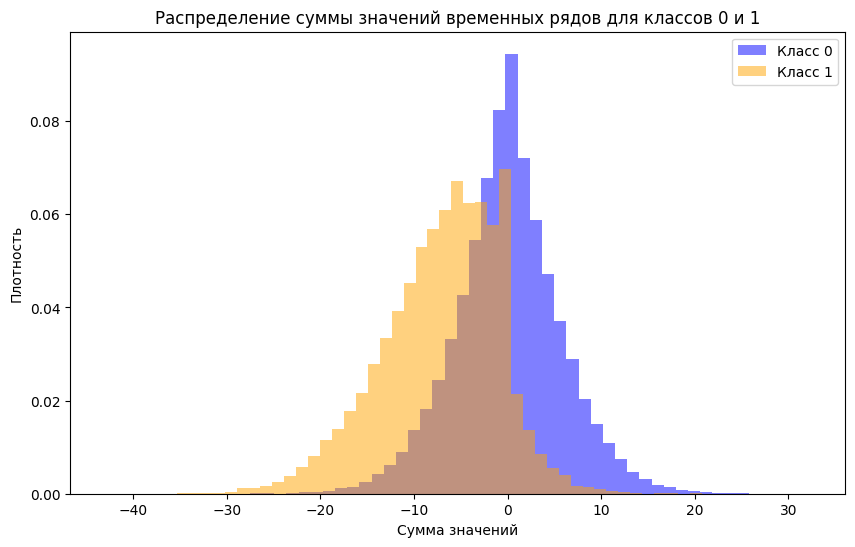

U-статистика: 1028183850.5
p-значение: 0.0
Существуют статистически значимые различия между классами по сумме значений временных рядов.


In [20]:
# 1. Рассчитаем сумму значений временных рядов для каждого id
train_df['sum_values'] = train_df['values'].apply(np.sum)
test_df['sum_values'] = test_df['values'].apply(np.sum)
# 2. Разделим данные на классы
class_0 = train_df[train_df['label'] == 0]['sum_values']
class_1 = train_df[train_df['label'] == 1]['sum_values']

# 3. Построим гистограммы для классов 0 и 1
plt.figure(figsize=(10, 6))
plt.hist(class_0, bins=50, alpha=0.5, label='Класс 0', color='blue', density=True)
plt.hist(class_1, bins=50, alpha=0.5, label='Класс 1', color='orange', density=True)
plt.legend(loc='upper right')
plt.title('Распределение суммы значений временных рядов для классов 0 и 1')
plt.xlabel('Сумма значений')
plt.ylabel('Плотность')
plt.show()

# 4. Проведём статистический тест Манна-Уитни
u_stat, p_value = mannwhitneyu(class_0, class_1, alternative='two-sided')

# 5. Вывод результатов
print(f'U-статистика: {u_stat}')
print(f'p-значение: {p_value}')

if p_value < 0.05:
    print('Существуют статистически значимые различия между классами по сумме значений временных рядов.')
else:
    print('Статистически значимых различий между классами по сумме значений временных рядов не обнаружено.')

Результаты пятой гипотезы показывают, что сумма значений временных рядов для классов 0 и 1 значительно различается. Это подтверждает статистическая значимость различий, так как p-значение равно 0. Это означает, что сумма значений временного ряда может быть значимым признаком для классификации классов.

Каким-то образом у нас появились пропуски, удалим их

In [24]:
# Проверка на наличие NaN значений в тренировочных данных
train_df.drop(['year', 'month'], axis=1, inplace=True)

train_df

C:\Users\rusbe\AppData\Local\Temp\ipykernel_4848\1733202475.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df.drop(['year', 'month'], axis=1, inplace=True)


,id,dates,values,label,amplitude,moving_avg,sum_values
0,19114,"[2016-01-01, 2016-02-01, 2016-03-01, 2016-04-0...","[-1.86, 0.79, 1.4, 0.15, 0.0, -1.24, -1.46, 3....",0.0,8.330000,"[0.10999999999999993, 0.78, 0.5166666666666666...",1.470000
1,22769,"[2016-05-01, 2016-06-01, 2016-07-01, 2016-08-0...","[-1.04, -3.48, 0.05, -0.13, -0.01, 0.03, 0.27,...",1.0,6.454409,"[-1.49, -1.1866666666666665, -0.03000000000000...",-13.984957
2,76935,"[2017-03-01, 2017-04-01, 2017-05-01, 2017-06-0...","[0.28, 0.63, 0.06, 0.96, -1.4, -0.3, 1.62, 1.1...",0.0,4.560000,"[0.32333333333333336, 0.5499999999999999, -0.1...",-2.210000
3,66297,"[2016-01-01, 2016-02-01, 2016-03-01, 2016-04-0...","[-0.33, 0.58, 1.1, -0.56, -0.95, -0.61, -0.7, ...",0.0,4.710000,"[0.45, 0.3733333333333334, -0.1366666666666666...",-6.240000
4,2191,"[2016-01-01, 2016-02-01, 2016-03-01, 2016-04-0...","[1.31, 0.5, -0.54, 0.95, 0.65, 0.83, -1.55, -0...",0.0,5.370000,"[0.4233333333333333, 0.30333333333333334, 0.35...",-15.150000
...,...,...,...,...,...,...,...
79995,71474,"[2018-10-01, 2018-11-01, 2018-12-01, 2019-01-0...","[-0.15, -1.13, -0.87, 0.49, 0.87, 1.67, 1.91, ...",0.0,6.200000,"[-0.7166666666666666, -0.5033333333333332, 0.1...",9.010000
79996,36908,"[2016-07-01, 2016-08-01, 2016-09-01, 2016-10-0...","[-0.35, -1.31, 0.11, 1.46, 1.28, 1.12, 1.78, 1...",1.0,4.750000,"[-0.5166666666666667, 0.08666666666666667, 0.9...",-5.965430
79997,63517,"[2016-03-01, 2016-04-01, 2016-05-01, 2016-06-0...","[-0.78, -2.27, -1.85, -0.67, -1.2, -2.02, 0.12...",0.0,5.160000,"[-1.6333333333333333, -1.5966666666666667, -1....",-10.270000
79998,94731,"[2016-02-01, 2016-03-01, 2016-04-01, 2016-05-0...","[-2.29, -2.85, 0.92, -0.83, -1.75, -1.81, -2.2...",0.0,5.960000,"[-1.4066666666666667, -0.9199999999999999, -0....",-4.750000


In [25]:
test_df.drop(['year', 'month'], axis=1, inplace=True)

In [28]:
train_df.fillna(0, inplace=True)
test_df.fillna(0, inplace=True)

C:\Users\rusbe\AppData\Local\Temp\ipykernel_4848\1134045971.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df.fillna(0, inplace=True)


# Preproccesing

Прежде чем приступать к модели, нужно обработать данные. Мы будем использовать:

**values** — временной ряд.
**amplitude** — амплитуда ряда.
**moving_avg** — скользящее среднее ряда.
**sum_values** — сумма значений временного ряда.
Каждый временной ряд должен быть преобразован в форму, подходящую для LSTM. Нам нужно разделить данные на обучающую и тестовую выборки, стандартизировать их и подготовить последовательности для LSTM.

In [36]:
from keras.preprocessing.sequence import pad_sequences

scaler = MinMaxScaler()

def preprocess_data_with_dates(df, is_train=True):
    X = []
    y = []

    for i, row in df.iterrows():
        # Признаки даты
        date_list = pd.to_datetime(row['dates'])
        month = np.array([date.month for date in date_list])   # Месяц
        quarter = np.array([date.quarter for date in date_list])  # Квартал

        # Признак values - это список
        values = np.array(row['values'])
        values = scaler.fit_transform(values.reshape(-1, 1)).flatten()

        # Признак moving_avg - это список
        moving_avg = np.array(row['moving_avg'])
        moving_avg = scaler.fit_transform(moving_avg.reshape(-1, 1)).flatten()

        # Остальные признаки - амплитуда, сумма, год, месяц
        extra_features = np.array([row['amplitude'], row['sum_values']])

        # Проверяем длину всех признаков и подгоняем их под длину основного временного ряда (values)
        min_length = min(len(values), len(moving_avg), len(month), len(quarter))

        # Обрезаем до минимальной длины
        values = values[:min_length]
        moving_avg = moving_avg[:min_length]
        month = month[:min_length]
        quarter = quarter[:min_length]

        # Повторяем дополнительные признаки для каждого шага временного ряда
        extra_features_repeated = np.repeat(extra_features.reshape(1, -1), min_length, axis=0)

        # Собираем все вместе: values, moving_avg, дата и остальные признаки
        combined_features = np.column_stack([values, moving_avg, month, quarter, extra_features_repeated])

        X.append(combined_features)

        if is_train:
            y.append(row['label'])

    if is_train:
        return X, np.array(y)
    else:
        return X

# Применяем к данным
X_train_raw, y_train = preprocess_data_with_dates(train_df, is_train=True)
X_test_raw = preprocess_data_with_dates(test_df, is_train=False)

# Приводим к одинаковой длине временные ряды для LSTM
X_train = pad_sequences(X_train_raw, dtype='float32', padding='post')
X_test = pad_sequences(X_test_raw, dtype='float32', padding='post')


c:\Users\rusbe\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\_array_api.py:695: RuntimeWarning: All-NaN slice encountered
  return xp.asarray(numpy.nanmin(X, axis=axis))
c:\Users\rusbe\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\_array_api.py:712: RuntimeWarning: All-NaN slice encountered
  return xp.asarray(numpy.nanmax(X, axis=axis))
c:\Users\rusbe\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\_array_api.py:695: RuntimeWarning: All-NaN slice encountered
  return xp.asarray(numpy.nanmin(X, axis=axis))
c:\Users\rusbe\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\_array_api.py:712: RuntimeWarning: All-NaN slice encountered
  return xp.asarray(numpy.nanmax(X, axis=axis))
c:\Users\rusbe\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\_array_api.py:695: RuntimeWarning: All-NaN slice encountered
  return xp.asarray(numpy.nanmin(X, axis=axis))
c:\Users\rusbe\AppDa

# Model

Построим модель с использованием функции активации - sigmoid и оптимизатором Adam.

In [37]:
def build_lstm_model(input_shape):
    model = Sequential()
    model.add(LSTM(64, input_shape=input_shape, return_sequences=False))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['AUC'])
    return model

In [38]:
# Проверим форму данных
print(f"X_train shape: {X_train.shape}")

X_train shape: (79912, 95, 6)


После обработки данных, вектор данных имеет неверные измерения, потому что я добавил дополнительные признаки (такие как amplitude, moving_avg, и т.д.), и их нужно учесть как часть "features", а не "timesteps".

In [40]:
# Исправляем input_shape
input_shape = (X_train.shape[1], X_train.shape[2])  # timesteps и features

In [41]:
# Строим модель
model = build_lstm_model(input_shape)

# Обучаем модель
model.fit(X_train, y_train, epochs=10, batch_size=64, validation_split=0.2)


c:\Users\rusbe\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/10
999/999 ━━━━━━━━━━━━━━━━━━━━ 38s 36ms/step - AUC: 0.8056 - loss: 0.4592 - val_AUC: 0.8814 - val_loss: 0.3884
Epoch 2/10
999/999 ━━━━━━━━━━━━━━━━━━━━ 34s 34ms/step - AUC: 0.8857 - loss: 0.3637 - val_AUC: 0.8945 - val_loss: 0.3578
Epoch 3/10
999/999 ━━━━━━━━━━━━━━━━━━━━ 38s 38ms/step - AUC: 0.8968 - loss: 0.3490 - val_AUC: 0.9015 - val_loss: 0.3499
Epoch 4/10
999/999 ━━━━━━━━━━━━━━━━━━━━ 35s 35ms/step - AUC: 0.8969 - loss: 0.3489 - val_AUC: 0.9022 - val_loss: 0.3470
Epoch 5/10
999/999 ━━━━━━━━━━━━━━━━━━━━ 36s 36ms/step - AUC: 0.8990 - loss: 0.3472 - val_AUC: 0.9065 - val_loss: 0.3381
Epoch 6/10
999/999 ━━━━━━━━━━━━━━━━━━━━ 38s 38ms/step - AUC: 0.9031 - loss: 0.3378 - val_AUC: 0.9046 - val_loss: 0.3457
Epoch 7/10
999/999 ━━━━━━━━━━━━━━━━━━━━ 32s 32ms/step - AUC: 0.9060 - loss: 0.3361 - val_AUC: 0.9094 - val_loss: 0.3370
Epoch 8/10
999/999 ━━━━━━━━━━━━━━━━━━━━ 33s 33ms/step - AUC: 0.9063 - loss: 0.3335 - val_AUC: 0.9081 - val_loss: 0.3364
Epoch 9/10
999/999 ━━━━━━━━━━━━━━━━━━━━ 

In [42]:
# Оценка модели на тренировочных данных
y_train_pred = model.predict(X_train)
roc_auc = roc_auc_score(y_train, y_train_pred)
print(f'ROC AUC на тренировочных данных: {roc_auc}')

2498/2498 ━━━━━━━━━━━━━━━━━━━━ 26s 10ms/step
ROC AUC на тренировочных данных: 0.9134313371770088


В итоге получаем достаточно хорошие результаты в 0.91 по ROC AUC.

Теперь можно созранить модель и использовать ее на тестовых данных.

In [47]:
model.save('lstm_model.h5')

Скрипт для создания submission.csv:

In [48]:
# Загрузка модели
model = load_model('lstm_model.h5')

# Генерация файла submission.csv
def generate_submission(model, X_test, output_file='submission.csv'):
    y_test_pred = model.predict(X_test)
    ids = test_df['id'].values
    submission = pd.DataFrame({'id': ids, 'score': y_test_pred.flatten()})
    submission.to_csv(output_file, index=False)

# Создаем файл submission.csv
generate_submission(model, X_test)

625/625 ━━━━━━━━━━━━━━━━━━━━ 6s 10ms/step
